In [ ]:
import os
import shutil
import PIL
import itertools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

import ipywidgets as widgets
from IPython.display import Image, display, clear_output

In [ ]:
from importlib import reload

# import .py files
import out_of_the_loop
import sampling

# reload modules
reload(out_of_the_loop)
reload(sampling)

# import classes and functions
from out_of_the_loop import GaussianProcess, BayesianOptimization, RandomGridSearch
from sampling import Metropolis

In [ ]:
def obj_func_2D(data, a=1, b=5.1/(4*np.pi**2), c=5/np.pi, r=6, s=10, t=1/(8*np.pi)):

    if not isinstance(data, np.ndarray):
        raise ValueError("data must be a NumPy array.")

    # to adjust x_query
    if data.ndim == 1:
        data = data.reshape(1, -1)

    x1 = data[:, 0]
    x2 = data[:, 1]

    y = a*(x2 - b*x1**2 + c*x1 - r)**2 + s*(1 - t)*np.cos(x1) + s

    return -y

In [ ]:
# global maxima
X_max = np.array([[-np.pi,12.275],[np.pi,2.275]])
Y_max = -np.array([0.39788736,0.39788736])

In [ ]:
np.random.seed(81234578)

# define step size along each dimension
x1_step = 0.5
x2_step = 0.5

# define range along each dimension
x1_min, x1_max = -5, 5
x2_min, x2_max = 0, 15

# create meshgrid for surface plot
x1 = np.arange(x1_min, x1_max + x1_step, x1_step)
x2 = np.arange(x2_min, x2_max + x2_step, x2_step)
xx1, xx2 = np.meshgrid(x1, x2)

# create matrix of positions
X_tot = np.vstack([xx1.ravel(), xx2.ravel()]).T

# observed locations and values
idx = np.random.choice(np.arange(X_tot.shape[0]), size=2, replace=False)
X = X_tot[idx,:]
Y = obj_func_2D(X)

# test locations
Xs = np.delete(X_tot, idx, axis=0)

# utils
meshgrid_cols = x1.shape[0]
meshgrid_rows = x2.shape[0]

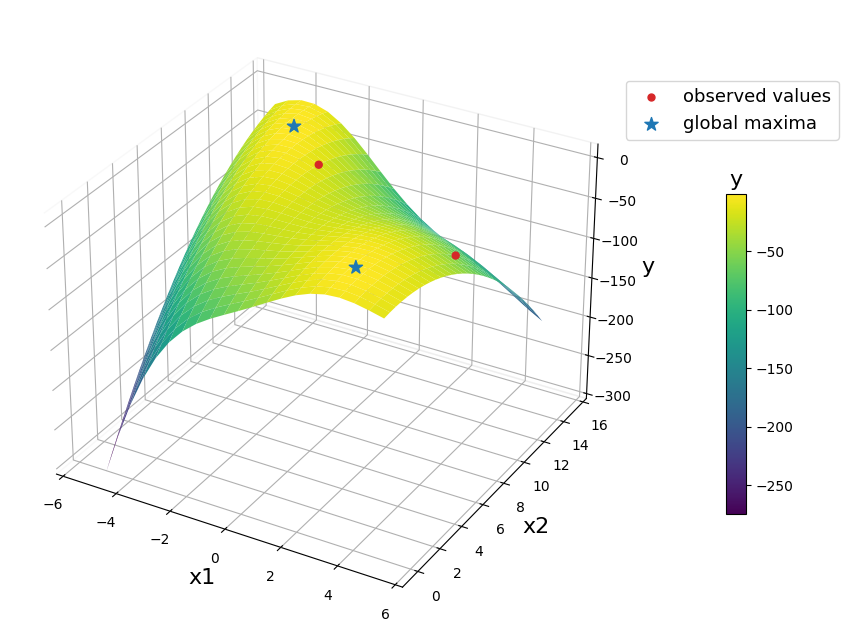

In [ ]:
Y_tot = obj_func_2D(X_tot)
yy_tot = Y_tot.reshape(meshgrid_rows, meshgrid_cols)

# plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d", computed_zorder=False)

surf = ax.plot_surface(xx1, xx2, yy_tot, cmap="viridis", alpha=1, antialiased=True, label="objective function", zorder=0)
ax.scatter(X[:,0], X[:,1], Y,  color="tab:red", alpha=1, marker=".", s=100, label="observed values", zorder=1)
ax.scatter(X_max[:,0], X_max[:,1], Y_max, color="tab:blue", alpha=1, marker="*", s=100, label="global maxima", zorder=2)

# add a colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.4])
cbar = fig.colorbar(surf, shrink=0.4, aspect=10, pad=0.1, cax=cbar_ax)
cbar.ax.set_title("y", rotation=0, fontsize=16)

ax.set_xlim([-6, 6])
ax.set_ylim([-1, 16])
ax.set_zlim([-300, 10])

ax.tick_params(axis="both", which="major", labelsize=10)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_zlabel("y", fontsize=16)

ax.view_init(elev=30, azim=-60, roll=0) # default 30, 60, 0

# create proxy artists for legend
observed_proxy = plt.scatter([], [], color="tab:red", alpha=1, marker=".", s=100)
maxima_proxy = plt.scatter([], [], color="tab:blue", alpha=1, marker="*", s=100)

# add legend for scatter plots
ax.legend([observed_proxy, maxima_proxy], ['observed values','global maxima'],bbox_to_anchor=(1.34, 0.5, 0.02, 0.4), fontsize=13)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.show()

## Gaussian process

In [ ]:
# parameters
var = 0
kernel = "matern_5"
theta = np.array([10, 10, 10])
#tuning = {"method": "off"}
#tuning = {"method": "MLE", "bounds": None}
tuning = {"method": "GD", "epochs": 100, "lr": 0.001}

In [ ]:
GP = GaussianProcess(X, Y, Xs, var, kernel, theta, tuning)
GP.active_learning()

- gradient descent started ...


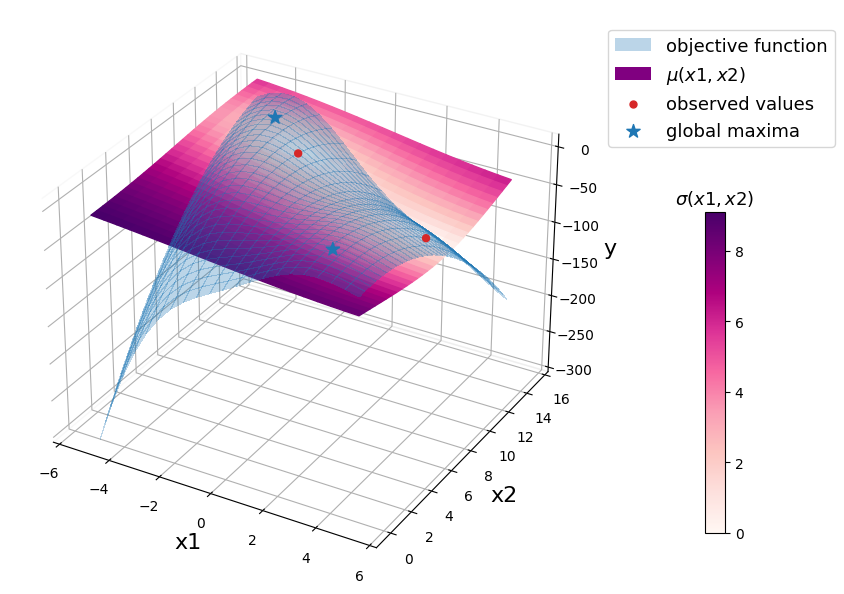

In [ ]:
# plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d", computed_zorder=False)


# objective function, posterior mean, posterior standard deviation
data = {
    "x1": np.append(GP.Xs[:, 0], GP.X[:, 0]),
    "x2": np.append(GP.Xs[:, 1], GP.X[:, 1]),
    "obj": np.append(obj_func_2D(GP.Xs), GP.Y),
    "mu": np.append(GP.mu, GP.Y),
    "std": np.append(np.sqrt(np.diag(GP.Sigma)), np.zeros(GP.Y.shape[0]))
}

df = pd.DataFrame.from_dict(data)
df = df.sort_values("x2")
df = df.groupby("x2").apply(lambda x: x.sort_values("x1"))

yy_obj = df["obj"].values.reshape(meshgrid_rows, meshgrid_cols)
yy_mu = df["mu"].values.reshape(meshgrid_rows, meshgrid_cols)
yy_std = df["std"].values.reshape(meshgrid_rows, meshgrid_cols)

norm = plt.Normalize(yy_std.min(), yy_std.max())

ax.plot_surface(xx1, xx2, yy_obj, color="tab:blue", shade=False, alpha=0.3, antialiased=False, label="objective function", zorder=1)
ax.plot_surface(xx1, xx2, yy_mu, facecolors=plt.cm.RdPu(norm(yy_std)), shade=False, alpha=1, antialiased=True, label=r"$\mu(x1,x2)$", zorder=0)
ax.scatter(GP.X[:,0], GP.X[:,1], GP.Y, color="tab:red", alpha=1, marker=".", s=100, label="observed values", zorder=2)
ax.scatter(X_max[:,0], X_max[:,1], Y_max, color="tab:blue", alpha=1, marker="*", s=100, label="global maxima", zorder=2)

# add a colorbar
mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.RdPu)
mappable.set_array(yy_std)
cbar_ax = fig.add_axes([0.82, 0.2, 0.02, 0.4])
cbar = fig.colorbar(mappable, cax=cbar_ax)
cbar.ax.set_title(r"$\sigma(x1,x2)$", rotation=0, fontsize=13)

ax.set_xlim([-6, 6])
ax.set_ylim([-1, 16])
ax.set_zlim([-300, 10])

ax.tick_params(axis="both", which="major", labelsize=10)
ax.set_xlabel("x1", fontsize=16)
ax.set_ylabel("x2", fontsize=16)
ax.set_zlabel("y", fontsize=16)

ax.view_init(elev=30, azim=-60, roll=0) # default 30, 60, 0

# create proxy artists for legend
obj_proxy = plt.Rectangle((0, 0), 1, 1, fc="tab:blue", alpha=0.3)
mu_proxy = plt.Rectangle((0, 0), 1, 1, fc="purple")
observed_proxy = plt.scatter([], [], color="tab:red", alpha=1, marker=".", s=100)
maxima_proxy = plt.scatter([], [], color="tab:blue", alpha=1, marker="*", s=100)

# add legend for scatter plots
ax.legend([obj_proxy, mu_proxy, observed_proxy, maxima_proxy], ['objective function', r'$\mu(x1,x2)$','observed values','global maxima'],bbox_to_anchor=(1.43, 0.58, 0.02, 0.4), fontsize=13)
fig.subplots_adjust(right=0.7)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.show()

## Bayesian optimization

In [ ]:
# parameters
acq_func = {"method": "EI", "tradeoff": 0.005}
marginalize_acq = {"status": False}
#marginalize_acq = {"status": True, "num_samples": 1000, "num_burns": 300, "thinning": 5, "std": 1}
n_query = 10

In [ ]:
BO = BayesianOptimization(X, Y, Xs, var, kernel, theta, tuning, obj_func_2D, acq_func, marginalize_acq, n_query)
BO.Bayesian_search()

Bayesian search started ...

Iteration 1/10
- gradient descent started ...
- theta: [10.26700711 10.0181025  10.00134647]
- non-positive var: []
- query point: [-5. 14.]

Iteration 2/10
- gradient descent started ...
- theta: [10.52740688  9.96272636  9.97815991]
- non-positive var: []
- query point: [-5.   5.5]

Iteration 3/10
- gradient descent started ...
- theta: [11.6838956   9.71735132  9.8795192 ]
- non-positive var: []
- query point: [ 0. 15.]

Iteration 4/10
- gradient descent started ...
- theta: [13.10973462  9.54969733  9.44384505]
- non-positive var: []
- query point: [-2.5 11. ]

Iteration 5/10
- gradient descent started ...
- theta: [14.06437383  9.16787622  8.99800147]
- non-positive var: []
- query point: [-4.  11.5]

Iteration 6/10
- gradient descent started ...
- theta: [14.7640731   7.24930343  8.54666373]
- non-positive var: []
- query point: [-2.5 11.5]

Iteration 7/10
- gradient descent started ...
- theta: [15.17983381  6.39947888  8.37737713]
- non-positive var

## Visualization

In [ ]:
DIR_PATH = "./images_2D"

if os.path.isdir(DIR_PATH):
    # remove directory
    shutil.rmtree(DIR_PATH)
    print("Directory '{}' removed".format(DIR_PATH))

if not os.path.isdir(DIR_PATH):
    # create directory
    os.mkdir(DIR_PATH)
    print("Directory '{}' created".format(DIR_PATH))

Directory './images_2D' removed
Directory './images_2D' created


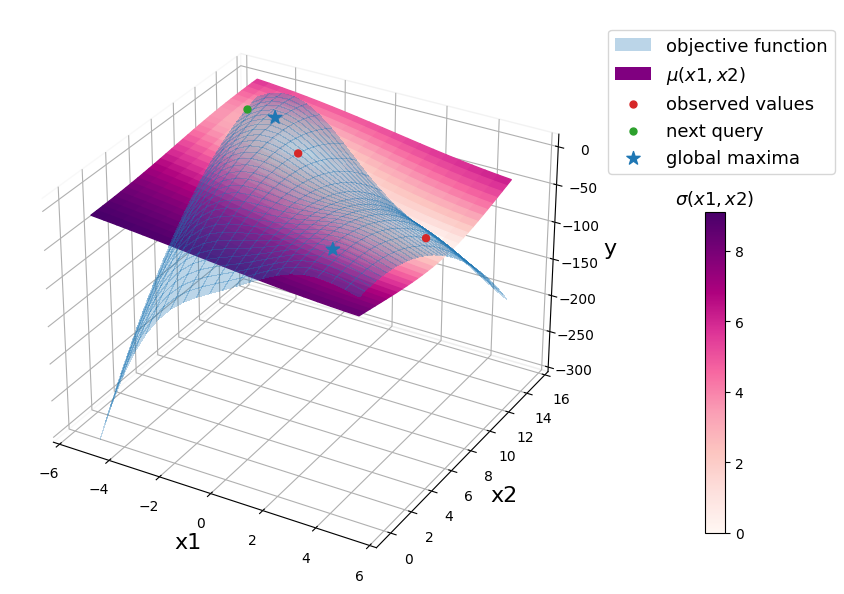

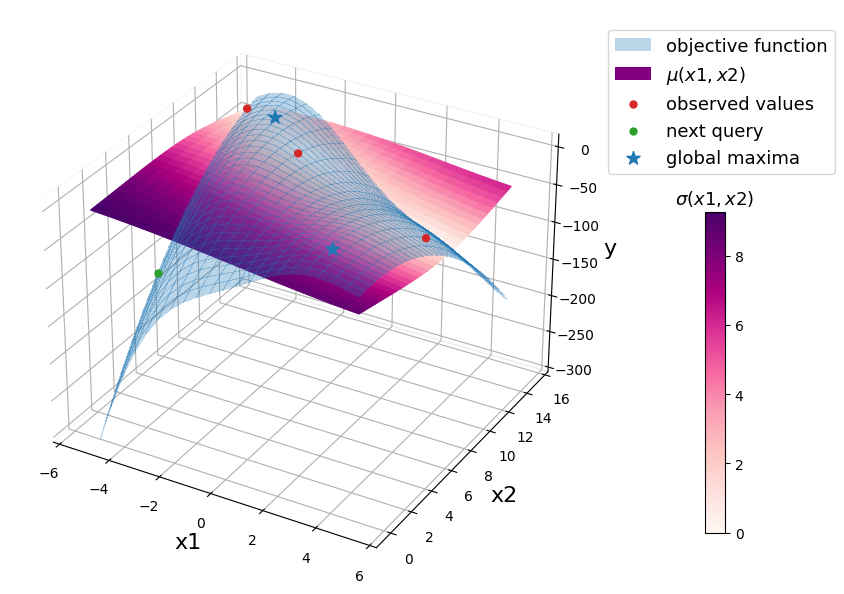

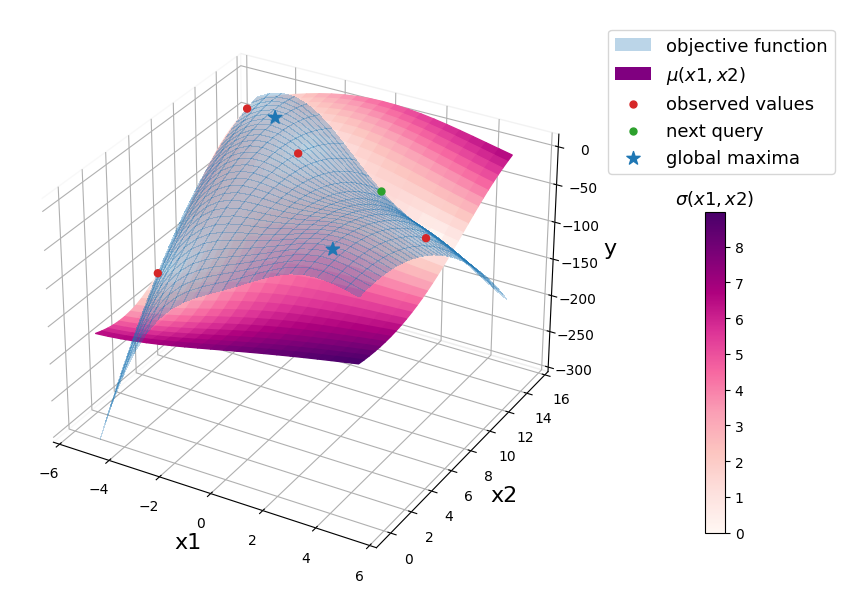

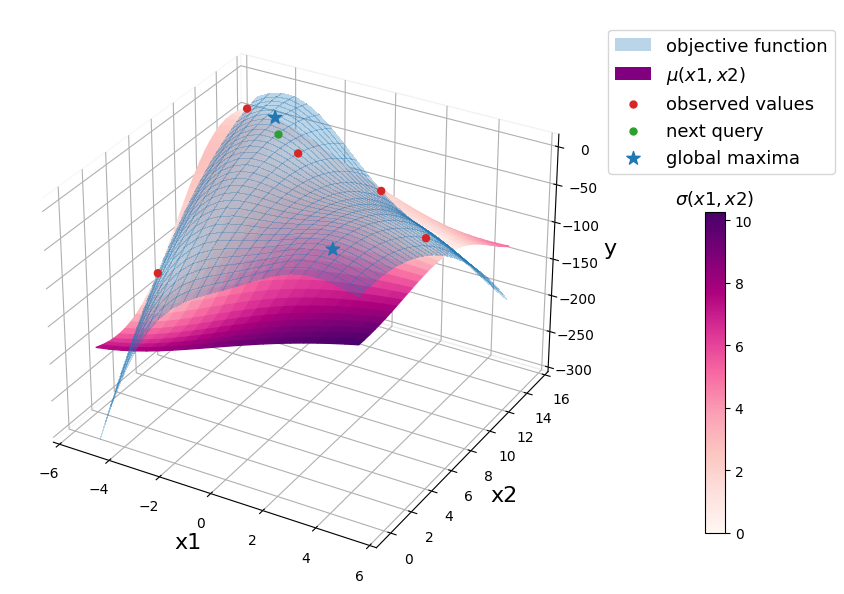

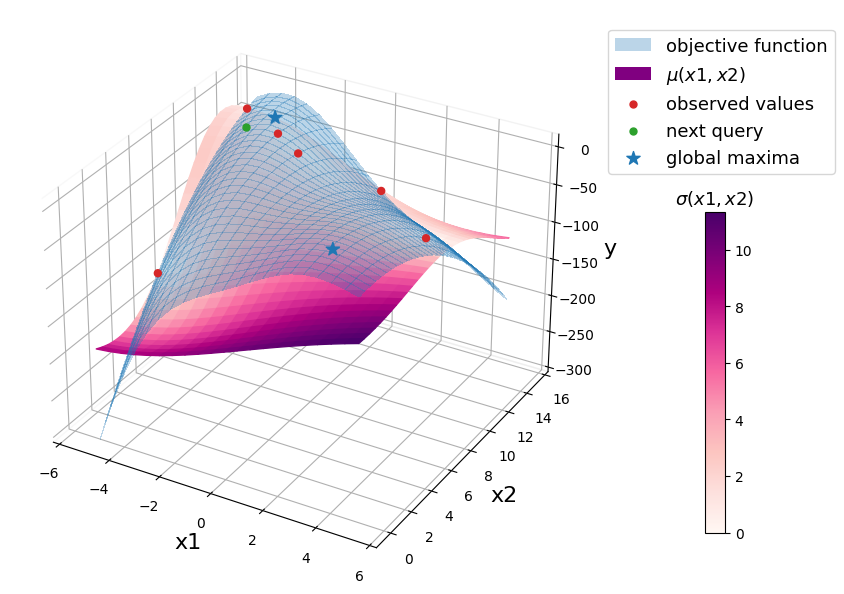

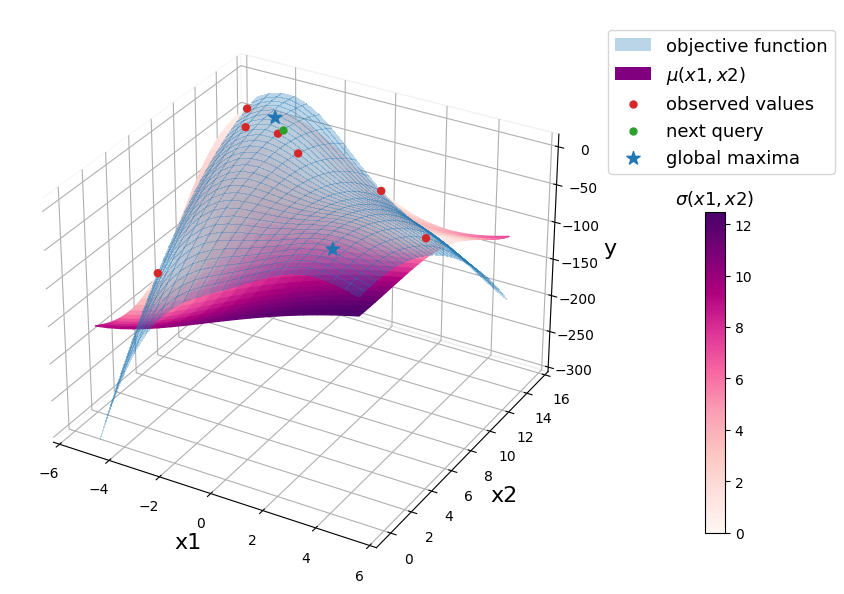

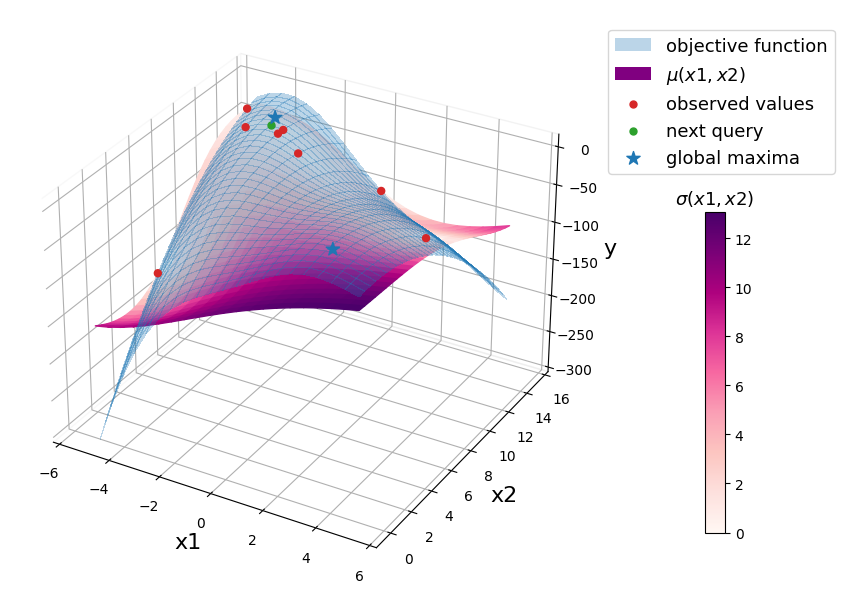

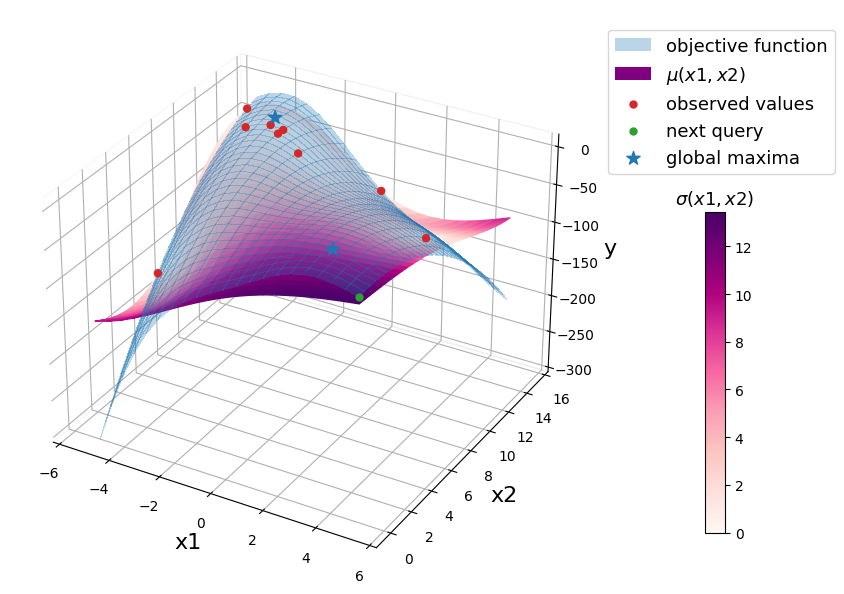

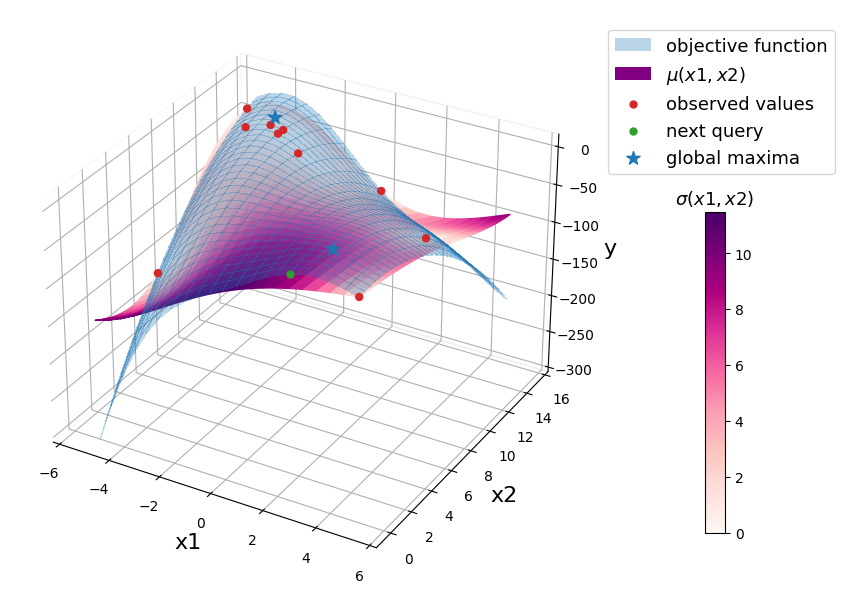

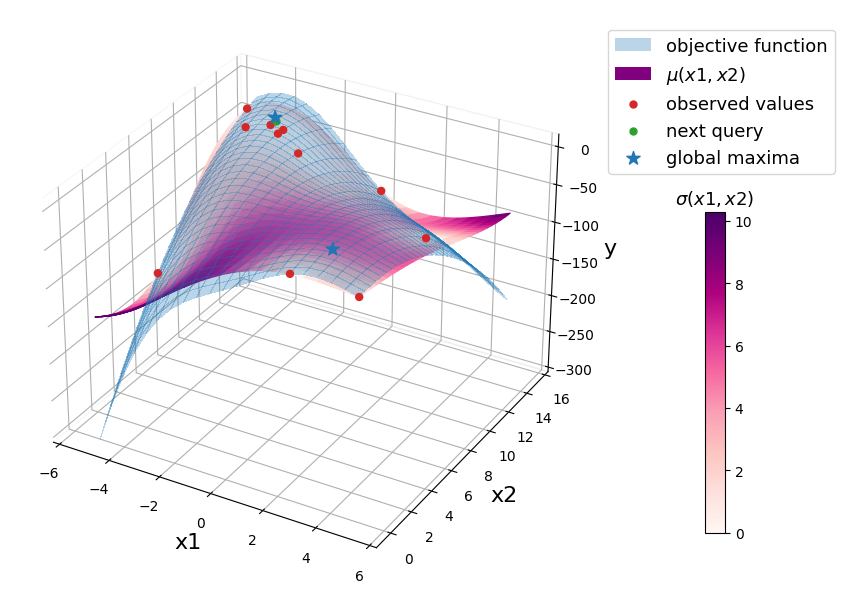

In [ ]:
for i in range(len(BO.X_log)):

    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection="3d", computed_zorder=False)

    data = {
        "x1": np.append(BO.Xs_log[i][:, 0], BO.X_log[i][:-1, 0]),
        "x2": np.append(BO.Xs_log[i][:, 1], BO.X_log[i][:-1, 1]),
        "obj": np.append(obj_func_2D(BO.Xs_log[i]), BO.Y_log[i][:-1]),
        "mu": np.append(BO.mu_log[i], BO.Y_log[i][:-1]),
        "std": np.append(np.sqrt(np.diag(BO.Sigma_log[i])), np.zeros(BO.Y_log[i][:-1].shape[0]))
    }

    df = pd.DataFrame.from_dict(data)
    df = df.sort_values("x2")
    df = df.groupby("x2").apply(lambda x: x.sort_values("x1"))

    yy_obj = df["obj"].values.reshape(meshgrid_rows, meshgrid_cols)
    yy_mu = df["mu"].values.reshape(meshgrid_rows, meshgrid_cols)
    yy_std = df["std"].values.reshape(meshgrid_rows, meshgrid_cols)

    norm = plt.Normalize(yy_std.min(), yy_std.max())
    colors = plt.cm.jet(norm(yy_std))

    ax.plot_surface(xx1, xx2, yy_obj, color="tab:blue", shade=False, alpha=0.3, antialiased=False, label="objective function", zorder=1)
    ax.plot_surface(xx1, xx2, yy_mu, facecolors=plt.cm.RdPu(norm(yy_std)), shade=False, alpha=1, antialiased=True, label=r"$\mu(x1,x2)$", zorder=0)
    ax.scatter(BO.X_log[i][:-1, 0], BO.X_log[i][:-1, 1], BO.Y_log[i][:-1], color="tab:red", alpha=1, marker=".", s=100, label="observed values", zorder=2)
    ax.scatter(BO.X_log[i][-1, 0], BO.X_log[i][-1, 1], BO.Y_log[i][-1], color="tab:green", alpha=1, marker=".", s=100, label="next query", zorder=2)
    ax.scatter(X_max[:,0], X_max[:,1], Y_max, color="tab:blue", alpha=1, marker="*", s=100, label="global maxima", zorder=2)

    # add a colorbar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.RdPu)
    mappable.set_array(yy_std)
    cbar_ax = fig.add_axes([0.82, 0.2, 0.02, 0.4])
    cbar = fig.colorbar(mappable, cax=cbar_ax)
    cbar.ax.set_title(r"$\sigma(x1,x2)$", rotation=0, fontsize=13)

    ax.set_xlim([-6, 6])
    ax.set_ylim([-1, 16])
    ax.set_zlim([-300, 10])

    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.set_xlabel("x1", fontsize=16)
    ax.set_ylabel("x2", fontsize=16)
    ax.set_zlabel("y", fontsize=16)

    ax.view_init(elev=30, azim=-60, roll=0) # default 30, 60, 0

    # create proxy artists for legend
    obj_proxy = plt.Rectangle((0, 0), 1, 1, fc="tab:blue", alpha=0.3)
    mu_proxy = plt.Rectangle((0, 0), 1, 1, fc="purple")
    observed_proxy = plt.scatter([], [], color="tab:red", alpha=1, marker=".", s=100)
    query_proxy = plt.scatter([], [], color="tab:green", alpha=1, marker=".", s=100)
    maxima_proxy = plt.scatter([], [], color="tab:blue", alpha=1, marker="*", s=100)

    # add legend for scatter plots
    ax.legend([obj_proxy, mu_proxy,observed_proxy,query_proxy, maxima_proxy], ['objective function', r'$\mu(x1,x2)$','observed values','next query','global maxima'],bbox_to_anchor=(1.43, 0.58, 0.02, 0.4), fontsize=13)
    fig.subplots_adjust(right=0.7)

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    plt.savefig(DIR_PATH + f"/{i:003}.png")

## GIF

In [ ]:
DIR_PATH = "./images_2D"
# collect images names
images = []
for filename in os.listdir(DIR_PATH):
    if filename.endswith(".png"):  # filter for files with a specific extension
        images.append(os.path.join(DIR_PATH, filename))
images.sort()

# get the frames
frames = [PIL.Image.open(img) for img in images]

# save into a GIF file that loops forever
frames[0].save("BO_2D.gif", format="GIF",
               append_images=frames[1:],
               save_all=True,
               duration=1300, loop=0)

## Comparison

In [ ]:
import itertools

# plot average comparison of different choice of method and hyperparameter (specified in the dictionary BO_dict)

def comparison(n_iteration, starting_points = 2, X_tot = X_tot, obj_func = obj_func_2D,
               seed = 654321, n_query = 15, RandomSearch = True,
               BO_dict = {'var': [0], 'kernel':['matern_5'], 'theta':[np.array([10,10,10])],
                          'tuning' : [{"method": "off"}, {"method": "MLE", "bounds" : None},  {'method':'GD', 'epochs':100, 'lr':0.001}],
                          'aquisition' : [{"method": "EI", "tradeoff": 0.005}]},
               marginalize_acq = {"status": False, "num_samples": 1000, "num_burns": 300, "thinning": 5, "std": 1}):

    verbose = False

    # set random seed
    np.random.seed(seed)

    if marginalize_acq.get('status') == True:
        BO_dict['tuning'].append({"method": "MAP"})

    # list of all possible combinations of elements in BO_dict
    BO_param_combination = list(itertools.product(*BO_dict.values()))



    # array of the cummulative maximum for each method and for each iteration
    cummax_log = np.zeros((n_iteration, n_query+starting_points, len(BO_param_combination)+RandomSearch))



    for i in range(n_iteration):

        # observed locations and values
        idx = np.random.choice(np.arange(X_tot.shape[0]), size = starting_points, replace=False)
        X = X_tot[idx,:]
        Y = obj_func(X)

        # test locations
        Xs = np.delete(X_tot, idx, axis=0)
        #print(Xs)

        print('\n Iteration: ', i+1)


        # Bayesian Optimization

        for p in range(len(BO_param_combination)):

            # Bayesian Optimization for each combinations of elements in BO_dict
            BO_param = BO_param_combination[p]
            #print('\n', BO_param)

            if BO_param[3] == {"method": "MAP"}:
                BO = BayesianOptimization(X, Y, Xs,
                          BO_param[0], BO_param[1], BO_param[2], {"method": "off"},
                          obj_func, BO_param[4], marginalize_acq, n_query, verbose)

            else:
                BO = BayesianOptimization(X, Y, Xs,
                                          BO_param[0], BO_param[1], BO_param[2], BO_param[3],
                                          obj_func, BO_param[4], {'status': False}, n_query, verbose)

            #print( BO_param[0], BO_param[1], BO_param[2], BO_param[3], obj_func, BO_param[4], BO_param[5], n_query, verbose)
            BO.Bayesian_search()

            # evaluate the cummulative maximum
            cummax_log[i,:, p] = list(itertools.accumulate(BO.Y, max))



        # Random Grid Search

        if RandomSearch:
            # Random Grid Search
            RS = RandomGridSearch(X, Y, Xs, obj_func, n_query, verbose)
            RS.random_search()

            # evaluate the cummulative maximum
            cummax_log[i,:, -1] = list(itertools.accumulate(RS.Y, max))

    return cummax_log, BO_param_combination, BO_dict


def plot_comparison(n_iteration, starting_points, RandomSearch, cummax_log, BO_param_combination, BO_dict, n_query):

    # Plot

    # mean
    cummax_mean = np.mean(cummax_log, axis=0)
    # error of the mean
    cummax_std_mean = np.std(cummax_log, axis=0)/np.sqrt(n_iteration)

    iterations = np.arange(n_query+starting_points)

    # list of indexes of BO_dict with more than one value
    comparison_param_ind =[i for i, key in enumerate(BO_dict.keys()) if len(BO_dict[key]) > 1]

    fig, ax = plt.subplots(figsize=(16,7))


    # Random Search
    if RandomSearch:
        ax.errorbar(iterations[2:], cummax_mean[2:,-1],
                    cummax_std_mean[2:,-1], label='Random Search', capsize=4,
                   fmt='o', ls='--')


    # Bayesian Optimization
    for l in range(len(BO_param_combination)):

        # label reporting only BO_dict elements with more than one value
        label = 'BO: '
        for m in comparison_param_ind:

            if list(BO_dict.keys())[m] == 'tuning':
                label += 'tuning' + ' = ' + BO_param_combination[l][m].get('method')

            elif list(BO_dict.keys())[m] == 'aquisition':
                label += 'acquisition ' + BO_param_combination[l][m].get('method')

            else:
                label += list(BO_dict.keys())[m] + ' = ' + str(BO_param_combination[l][m])

            if m != comparison_param_ind[-1]: label += ', '

        ax.errorbar(iterations[2:], cummax_mean[2:,l],
                    cummax_std_mean[2:,l], label=label, capsize=4,
                   fmt='o', ls='--')

        ax.legend(loc = 'lower right', fontsize=16)
        ax.grid(ls='--')
        ax.set_xlabel('function evaluations', fontsize=18)
        ax.set_ylabel('max function value', fontsize=18)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.savefig('filename.png', dpi=300)
        #ax.set_title('Methods comparison', fontsize=18)


 Iteration:  1
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  2
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  3
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  4
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  5
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  6
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  7
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  8
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search star

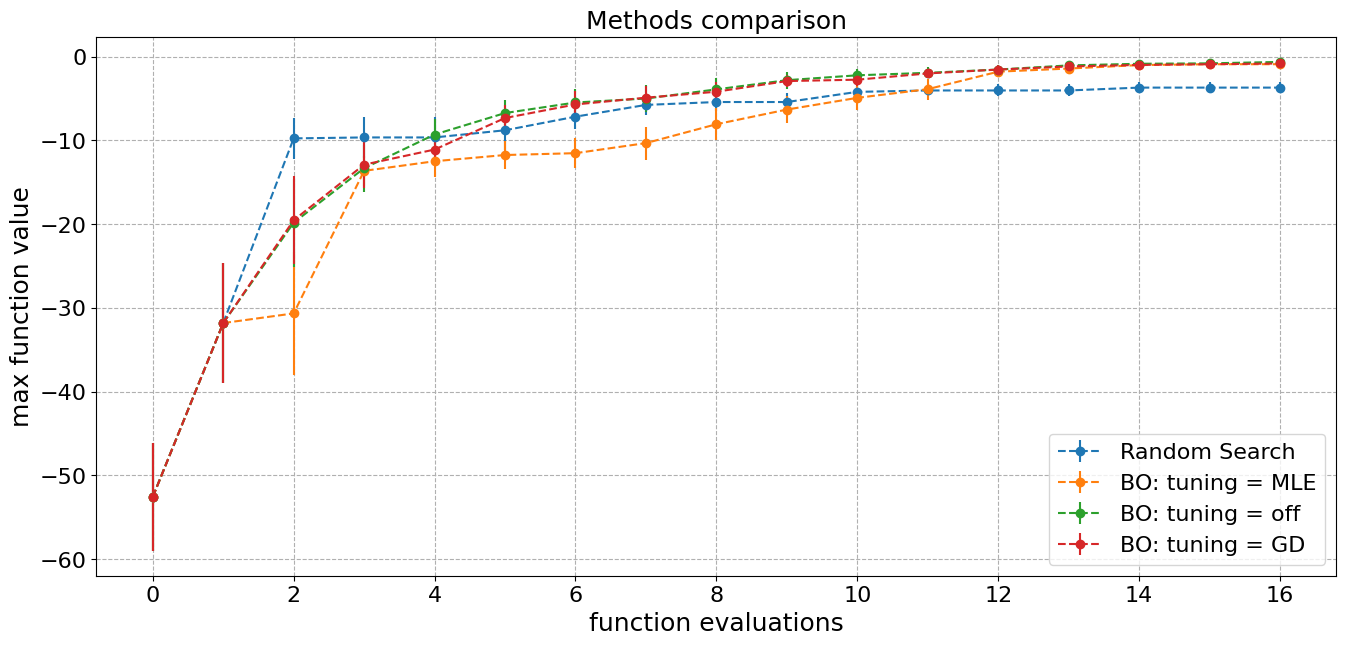

In [ ]:
cummax_log, BO_param_combination, BO_dict = comparison(10)

In [ ]:
plot_comparison(10, 2, True, cummax_log, BO_param_combination, BO_dict, 15)


 Iteration:  1
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  2
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  3
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  4
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  5
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  6
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  7
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search started ...

 Iteration:  8
Bayesian search started ...
Bayesian search started ...
Bayesian search started ...
Random search star

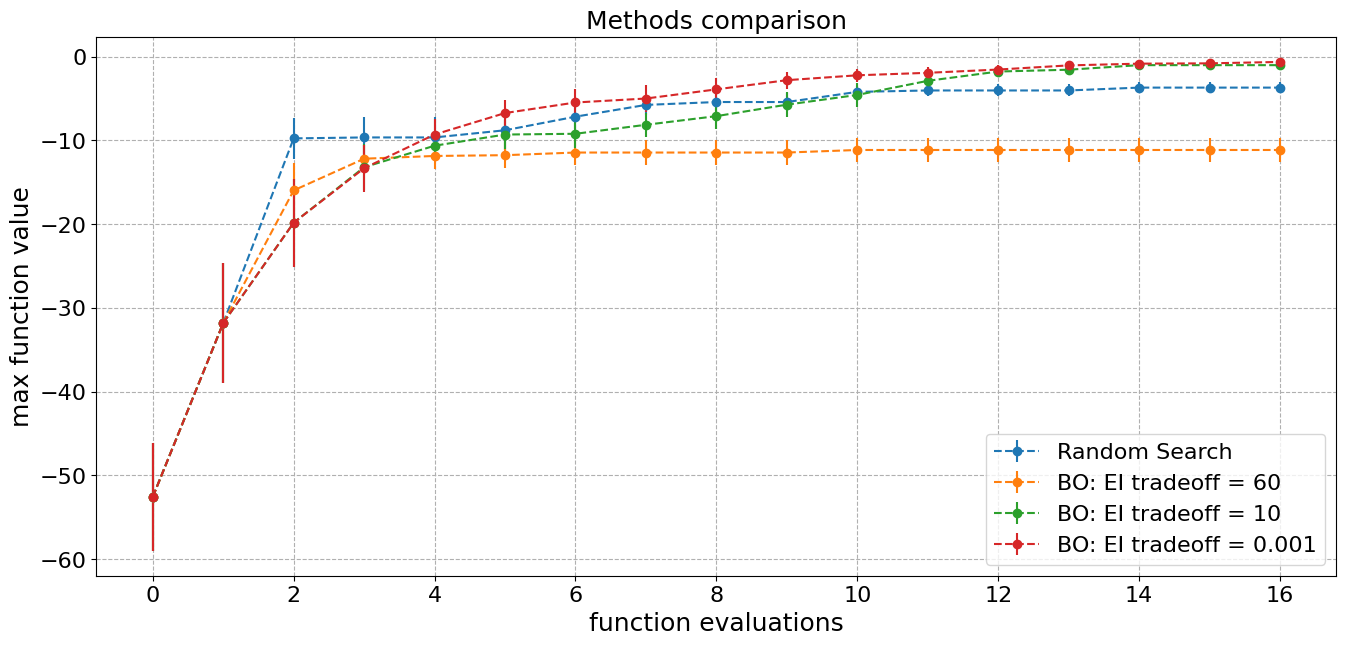

In [ ]:
cummax_log, BO_param_combination, BO_dict = comparison(n_iteration=10, starting_points = 2, X_tot = X_tot, obj_func = obj_func_2D,
               seed = 654321, n_query = 15, RandomSearch = True,
               BO_dict = {'var': [0], 'kernel':['matern_5'], 'theta':[np.array([10,10,10])],
                          'tuning' : [{"method": "off"}],
                          'aquisition' : [{"method": "EI", "tradeoff": 0.005}, {"method": "PI", "tradeoff": 0.005}, {"method": "UCB", "tradeoff": 1}]},
               marginalize_acq = {"status": False, "num_samples": 1000, "num_burns": 300, "thinning": 5, "std": 1})

In [ ]:
plot_comparison(10, 2, True, cummax_log, BO_param_combination, BO_dict, 15)